In [1]:
# Importing general python modules
import numpy as np
import astropy.constants as const
import astropy.units as u
# Plotting packages
import matplotlib.pyplot as plt
import matplotlib
# Importing the modules to be used in the class.
from GalaxyMass import ComponentMass
from CenterOfMass_2 import CenterOfMass
from IPython.display import Latex
from ReadFile import Read

In [2]:
class M33AnalyticOrbit:
    
    def __init__(self,filename):
        ''' Initiating the class.
        INPUTS: output filename (defined below)'''
        
        # Instantiating G's value without units.
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        # defining the output file.
        self.filename = '%s.txt'%(filename)
        
        # Instantiating CenterOfMass for M33.
        M33 = CenterOfMass('M33_000.txt',2)
        
        # Calling the COM_P and COM_V functions to find the center of mass pos/vel of M33
        self.M33r = M33.COM_P(0.1,4.0)
        self.M33v = M33.COM_V(self.M33r[0],self.M33r[1],self.M33r[2])
        # Instantiating center of mass for M31.
        M31 = CenterOfMass('M31_000.txt',2)
        
        # Calling COM_P and COM_V functions in CenterOfMass to calculate pos/vel of M31.
        self.M31r = M31.COM_P(0.1,2.0)
        self.M31v = M31.COM_V(self.M31r[0],self.M31r[1],self.M31r[2])
        
        # Difference of the po/vel vectors of M33 and M31.
        self.r0 = np.array(self.M33r) - np.array(self.M31r)
        self.v0 = np.array(self.M33v) - np.array(self.M31v)
        
        # scale length for disk
        self.rdisk = 5
        # calling the component mass function to calculate the disk mass (ptype = 2)
        self.Mdisk = ComponentMass('M31_000.txt',2)
        # scale length of bulge.
        self.rbulge = 1
        # calculating the bulge mass (ptype = 3)
        self.Mbulge = ComponentMass('M31_000.txt',3)
        # scale radius for halo
        self.rhalo = 62
        # calculating the halo mass (ptype = 1)
        self.Mhalo = ComponentMass('M31_000.txt',1)
        
        
    def HernquistAccel(self, M, r_a,x,y,z):
        '''Function to calculate the gravitational acceleration of bulge and halo mass
        through the Hernquist profile.
        INPUTS: mass (bulge or halo) in M_sun, scale radius (r_a), relative distance between the galaxies
        represented by the vector (x,y,z)
        RETURNS: The gravitational acceleration VECTOR.'''
        # defining the x,y,z coordinates of the M33-M31 distance.
    
        x = self.r0[0]
        y = self.r0[1]
        z = self.r0[2]
        r = np.sqrt(x*x + y*y + z*z)
        # calculating the gravitational acceleration.
    
        a_x = -(self.G)*M/r/(r+r_a)**2*x
        a_y = -(self.G)*M/r/(r+r_a)**2*y
        a_z = -(self.G)*M/r/(r+r_a)**2*z
        # assigning the components of the acceleration to an array (aBulgeHalo)
        aHernquist = np.array([a_x.value,a_y.value,a_z.value])
        return aHernquist
        
    def MiyamotoNagaiAccel(self, M, rd, x, y, z):
        ''' Function to calculate the gravitational acceleration of disk particles through the Miyamoto
        Nagai profile. 
        INPUTS: mass (in M_sun), scaling length (r_disk), relative distance between the galaxies, 
        represented by a vector.
        RETURNS: the gravitational acceleration of disk particles.'''
        # Same as in HernquistAccel
        x = self.r0[0]
        y = self.r0[1]
        z = self.r0[2]
        # defining extra terms required for the calculation.
        rd = self.rdisk
        zd = rd/5.0
        R = np.sqrt(x**2 + y**2)
        B = rd + np.sqrt(z**2 + zd**2)
            
        # calculating the x,y and z components of the acceleration.
        a_x = -self.G*M/(R**2 + B**2)**1.5*x
        a_y = -self.G*M/(R**2 + B**2)**1.5*y
            
        az1 = -self.G*M/(R**2 + B**2)**1.5*z
        a_z = az1*B/np.sqrt(z**2 + zd**2)
            
        # assigning the components of the acceleration to an a array (aDisk)
        aDisk = np.array([a_x.value,a_y.value,a_z.value])
        return aDisk
        
    def M31Accel(self, x, y, z):
        ''' Function to calculate the total acceleration VECTOR of M31.
        INPUTS: (x,y,z) coordinates of the M33-M31 distance.
        RETURNS: the total acceleration of M31.'''
            
        aTotal = self.HernquistAccel(self.Mbulge,self.rbulge,x,y,z) + self.HernquistAccel(self.Mhalo,self.rhalo,x,y,z) + self.MiyamotoNagaiAccel(self.Mdisk,self.rdisk,x,y,z)
        return aTotal
    
        
    def LeapFrog(self,dt,r,v):
        '''defining a function that calculates the relative positions and velocities of the galaxies
        at various timesteps.
        INPUTS: time interval (dt), distance between the two galaxies (x,y,z) and relative velocities
        of the two galaxies (vx,vy,vz)
        RETURNS: the relative position and velocity at full timestep. '''
        
        # Refer to the HW-7 guidelines where these formulae are laid out.
        r_half = r + v*dt/2
        # assigning the components to an array.
            
        v_full = v + self.M31Accel(r_half[0],r_half[1],r_half[2])*dt
            
        r_full = r_half + v_full*dt/2
            
        return r_full,v_full
            
    def OrbitIntegrator(self,t0,dt,tmax):
        '''defining a function that loops over the LeapFrog function and updates the kinematics of 
        galaxies at various times.
        INPUTS: starting time (t0), ending time (tmax), time interval (dt)
        RETURNS: a file containing the relative distances and velocities of M33-M31 system at various 
        times.'''
            
        t = t0
        
        # initializing an array
        Orbit = np.zeros([int(tmax/dt)+2, 7])
        # defining the first row of the array.
        Orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # initializing array elements
        i = 1
                
        while t<=tmax: # as long as t does not cross tmax:
            t += dt # update time by dt
            Orbit[i,1] = t # the first column of the array will have time
            
            rnew,vnew = self.LeapFrog(dt,self.r0,self.v0) # calculating new positions and velocites.
            self.r0 = rnew # updating position and velocity in each step
            self.v0 = vnew
            # store the positions and velocities in the respective columns.
            Orbit[i,1:4] = rnew
            Orbit[i,4:7] = vnew
            # update the array element.
            i += 1
            
        
                
        # save the output file.        
        np.savetxt(self.filename,Orbit,fmt = "%11.3f"*7, comments='#',
                    header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                            .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz')) 
        
# Acknowledgement: This code was completed with the assistance of Dr. Besla, Rixin Li
# and my classmate Joseph Hickey.

In [3]:
Integrate = M33AnalyticOrbit('Integrated_Orbit') # instantiating the class

In [4]:
Integrate.OrbitIntegrator(0,0.1,10)

In [5]:
# extracting the distance and velocity vectors from Integrated_Orbit.txt and storing them in arrays.
Dist = np.genfromtxt('Integrated_Orbit.txt',dtype=None,names=None,usecols=(1,2,3))
Vel = np.genfromtxt('Integrated_Orbit.txt',dtype=None,names=None,usecols=(4,5,6))


In [6]:
def Mag(array):
    '''Simple function to calculate the magnitude of any vector.
    INPUT: an array representing a 3D vector.
    RETURNS: The magnitude of the vector'''
    
    X = array[:,0] # x-components in an array.
    
    Y = array[:,1]  #  y-components in an array.
    
    Z = array[:,2] #  z-components in an array.
    
    mag = np.sqrt(X**2 + Y**2 + Z**2) # magnitude of the vector.
    
    return mag

In [7]:
mag_dist = Mag(Dist) # magnitude of the separation vector
mag_vel = Mag(Vel) # magnitude of the velocity vector

Text(0.5, 1.0, 'Relative distance in 12 Gyr')

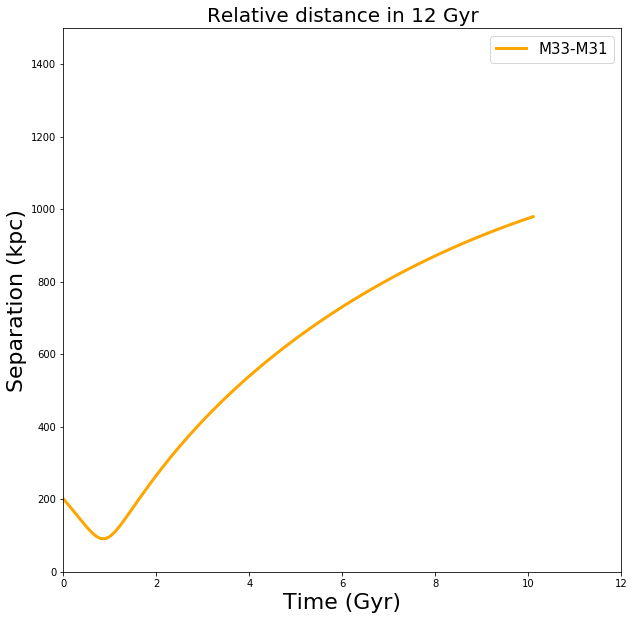

In [8]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
t = np.arange(0,10.2,0.1)

# plotting seperation between M33 and M31 over a period of 12 Gyr.
plt.plot(t, mag_dist, color='orange', linewidth=3, label='M33-M31')


# the axes labels
plt.xlabel('Time (Gyr)', fontsize=22)
plt.ylabel('Separation (kpc)', fontsize=22)

# Axes limits:
plt.xlim(0,12)
plt.ylim(0,1500)

# Customized legend
ax.legend(loc = 'upper right',frameon = True, prop={'size':15})

# plot title
plt.title('Relative distance in 12 Gyr', fontsize = 20)

Text(0.5, 1.0, 'Relative velocity in 12 Gyr')

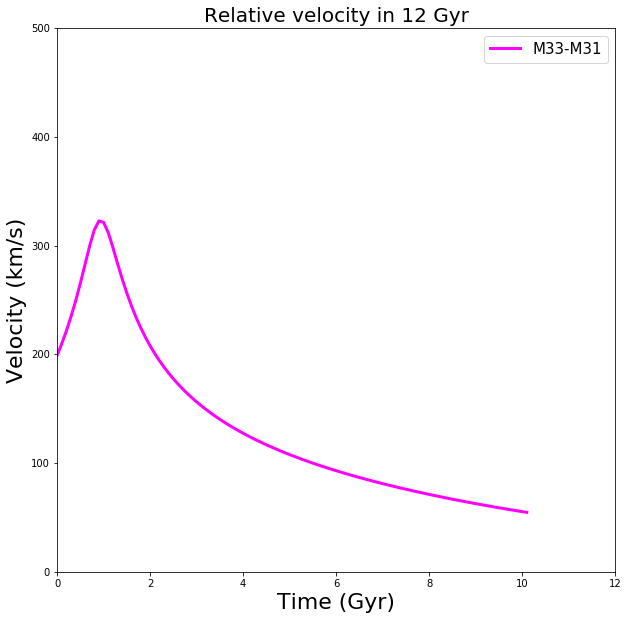

In [9]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
t = np.arange(0,10.2,0.1)

# plotting relative velocity between M33 and M31 over a period of 12 Gyr.
plt.plot(t, mag_vel, color='magenta', linewidth=3, label='M33-M31')


# the axes labels
plt.xlabel('Time (Gyr)', fontsize=22)
plt.ylabel('Velocity (km/s)', fontsize=22)

# Axes limits:
plt.xlim(0,12)
plt.ylim(0,500)

# Customized legend
ax.legend(loc = 'upper right',frameon = True, prop={'size':15})

# plot title
plt.title('Relative velocity in 12 Gyr', fontsize = 20)

The simulation from HW-6 show that the M33-M31 system will undergo multiple encounters before merging into one system while the analytical solution seems to imply that there is going to be only one interaction between the two galaxies. The closest approach (according to the analytical solution) will happen sometime in the next 1 billion years.

The outcomes in the graphs are quite different because we have not accounted for the Milky Way's gravitational affect on the interaction of M31-M33. The MW-M31-M33 system make a three-body problem that has no solutions theoretically. So, to account for the MW's affect we would have to perform numerical simulations and approximations in this case (or treat it as a reduced mass problem). The reason M33 flies off to a greater distance in this case is because it is not affected by the Milky Way's mass (because we have not accounted for it). 
Thus, in order for the analytical solution to mimic the simulations from HW-6, we need to account for the affects of Milky Way on this M33-M31 system.

We could include the Milky Way's affect on this system by treating it as a reduced mass problem (Mass1 = MW mass and Mass2 = M31+M33 mass).